# Measuring Communication Efficiency and Learnability of Colors using an Information Bottleneck Framework

In [1]:
import pandas as pd
import numpy as np
from ibhelpers import *

In [2]:
# load the data from the World Color Survey
term_df = pd.read_csv("wcs/term.txt", delimiter="\t", header=None)
term_df.columns = ["language", "speaker", "chip", "word"]

## Calculate prior probabilities

For each language, $l$, we can use a frequentist approach (counts) to calculate the observed quantities of $p(w|c,l)$ and $p(c|w,l)$

In [28]:
# per_chip_count_df = df.groupby(["language", "chip", "word"]).speaker.agg(individual_count_per_word_per_chip="count")
# total_word_count_df = df.groupby(["language", "chip"]).word.agg(total_words_per_chip="count")

# # frequentist probability of a word given chip and language
# p_word_chip_language = per_chip_count_df["individual_count_per_word_per_chip"] / total_word_count_df["total_words_per_chip"]
# p_word_chip_language.head(5)

In [29]:
# per_word_count_df = df.groupby(["language", "word", "chip"]).speaker.agg(individual_count_per_chip_per_word="count")
# total_chip_count_df = df.groupby(["language", "word"]).chip.agg(total_chips_per_word="count")

# # frequentist probability of a chip given word and language
# p_chip_word_language = per_word_count_df["individual_count_per_chip_per_word"] / total_chip_count_df["total_chips_per_word"]
# p_chip_word_language.head(5)

In [ ]:

def unmerge_cols(q):
    num_cols = q.shape[1]
    if num_cols < 330:
        duplicate_vector = np.ones(num_cols, dtype=int)
        duplicate_vector[-1] = 331 - num_cols
        q = np.repeat(q, duplicate_vector, axis=1)
    q[:,330-duplicate_vector[-1]:] /= duplicate_vector[-1]
    q[np.isnan(q)] = 0
    # uniform dist for q va
    q[q.sum(1) == 0] = 1 / q.shape[0]
    
    assert 330 - q.sum() < 0.01
    return q
    
# Get a q given a language id and term.txt / sample.csv file 
# q is a matrix that is (330 x W) that describes the probability of a word given color chip
def get_q_for_language(language_id: int, term_file=None, mergecols=False):
    if term_file is None:
        df = pd.read_csv("wcs/term.txt", delimiter="\t", header=None)
        df.columns = ["language", "speaker", "chip", "word"]
    else:
        df = pd.read_csv(term_file)

    per_chip_count_df = df.groupby(["language", "chip", "word"]).speaker.agg(individual_count_per_word_per_chip="count")
    total_word_count_df = df.groupby(["language", "chip"]).word.agg(total_words_per_chip="count")
    p_word_chip_language = per_chip_count_df["individual_count_per_word_per_chip"] / total_word_count_df["total_words_per_chip"]
    tmp_df = p_word_chip_language.reset_index()
    
    language_df = tmp_df[tmp_df.language == language_id].copy()
    language_df.word = language_df.word.astype('category').cat.codes
    
    q = np.zeros((330, language_df.word.nunique()))
    for i, row in language_df.iterrows():
        q[int(row["chip"])-1][int(row["word"])] = row[0]
    
    if mergecols:
        return q
    q = unmerge_cols(q)
    return q

# Get a q given a language id and term.txt / sample.csv file 
# q is a matrix that is (330 x W) that describes the probability of a word given color chip
def get_q_for_som_language(language_id: int, sample_size: int, term_file=None):
    if term_file is None:
        df = pd.read_csv("wcs/term.txt", delimiter="\t", header=None)
        df.columns = ["language", "speaker", "chip", "word"]
    else:
        df = pd.read_csv(term_file, delimiter="\t", header=None)
        df.columns = ["language", "speaker", "chip", "word"]
        
    
    df = df[:sample_size].copy()

    per_chip_count_df = df.groupby(["language", "chip", "word"]).speaker.agg(individual_count_per_word_per_chip="count")
    total_word_count_df = df.groupby(["language", "chip"]).word.agg(total_words_per_chip="count")
    p_word_chip_language = per_chip_count_df["individual_count_per_word_per_chip"] / total_word_count_df["total_words_per_chip"]
    tmp_df = p_word_chip_language.reset_index()
    
    language_df = tmp_df[tmp_df.language == language_id].copy()
    language_df.word = language_df.word.astype('category').cat.codes
    
    q = np.zeros((330, language_df.word.nunique()))
    
    for i, row in language_df.iterrows():
        q[int(row["chip"])-1][int(row["word"])] = row[0]
    
    q = unmerge_cols(q)
    return q

In [5]:
# from tqdm import tqdm
# import glob
# seed = 42

# # go over all sample files and calculate q directly from sample instead of from learnability encoder
# sample_files = glob.glob(f"output/learnability/42/*_samples.csv")
# with tqdm(total=(len(sample_files)*110)) as pbar:
#     for sample_file in sample_files:
#         i = int(sample_file.split("_")[0].split("/")[-1])
#         for l in range(1, 111):
#             q = get_q_for_language(l, term_file=sample_file)
#             np.save(f"output/learnability/42/{l}/sample_{i}.npy", q)
#             pbar.update(1)
#             break
#         break


In [6]:
# from tqdm import tqdm
# import glob
# seed = 42

# sample_range = (
#     list(range(1, 25, 1))
#     + list(range(25, 50, 5))
#     + list(range(50, 100, 10))
#     + list(range(100, 220, 20))
#     + list(range(250, 1000, 50))
#     + list(range(1000, 2100, 100))
# )

# sample_files = glob.glob(f"output/som/{seed}/*/*_samples.csv")
# with tqdm(total=(len(sample_files)*len(sample_range))) as pbar:
#     for sample_file in sample_files:
#         l = int(sample_file.split("_")[0].split("/")[-2])
#         for s in sample_range:
#             q = get_q_for_som_language(l, s, term_file=sample_file)
#             np.save(f"output/som/{seed}/{l}/sample_{s}.npy", q)
#             pbar.update(1)
#             break
#         break

## Information Bottleneck

Code taken from Frank (osfstorage)

### Initialise components for optimising IB objective

We need to initialise a joint prior distribution of words and meanings, i.e. `p_wm`, and a corresponding variational joint distribution, i.e. `q0` (q_wm_0).

In [7]:
# number of possible meanings
n_meanings = 330

# to avoid underflow problem
eps = 0.00001
q0 = (1 - eps) * np.eye(n_meanings) + eps * np.ones((n_meanings, n_meanings))

Calculate $p(x|y)$ (p_xGy) using a PDF over chips in lab space

In [8]:
from scipy.stats import norm, multivariate_normal
from scipy.special import softmax

p_xGy = np.zeros((n_meanings, n_meanings))

chip2lab = pd.read_csv("wcs/cnum-vhcm-lab-new.txt", sep="\t", header=0, index_col="#cnum")
chip2lab = chip2lab.sort_values(by="#cnum")[["L*", "a*", "b*"]].copy().reset_index()

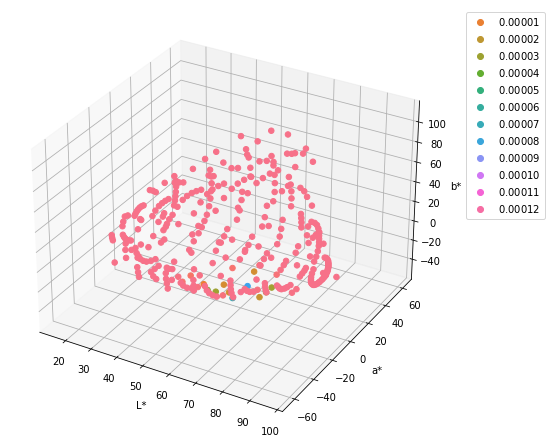

In [14]:
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

labspace = chip2lab[["L*", "a*", "b*"]].values
COVARIANCE = 64 # @TODO: This is a hyperparameter than needs to be justified

for i in range(n_meanings):
    # the multivariate pdf over the lab space dimension to go back into chip/meaning space 
    p_xGy[i] = multivariate_normal.pdf(labspace, mean=labspace[i], cov=COVARIANCE)

# generate data
n = 200
x = labspace[:,0]
y = labspace[:,1]
z = labspace[:,2]

# We will plot the pdf for the first chip in Lab space
# to check that some probability is being assigned to each surrounding chip
c = p_xGy[0]

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=30, c=c, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('L*')
ax.set_ylabel('a*')
ax.set_zlabel('b*')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [15]:
from communication import MutualInfoCalculator
mi = MutualInfoCalculator()
p_x = mi.get_px("./wcs/term.txt")

TypeError: missing chip data for language 26


In [16]:
betas = np.array([2 ** x for x in np.arange(0.7, 0.5, -0.1)])
print(betas)
focalbeta = 1.0

# calculate p_xy from p_x and p_xGy
p_xGy = p_xGy / p_xGy.sum(axis=1, keepdims=True)
p_xy = p_xGy * p_x[:, np.newaxis]
p_xy = p_xy / np.sum(p_xy)

[1.62450479 1.51571657]


### Score all languages

In [ ]:

languages = []
rates = []
distortions = []
# for l in tqdm(df.language.unique()):
for l in tqdm(range(1,111)):
    q = get_q_for_language(l)
    res = score_q_kl(p_xy, q)
    rates.append(res.rate)
    distortions.append(res.distortion)
    languages.append(l)

language_scores = pd.DataFrame()
language_scores["language"] = languages
language_scores["rate"] = rates
language_scores["distortion"] = distortions


language_scores.to_csv("output/language_scores.csv", index=False)

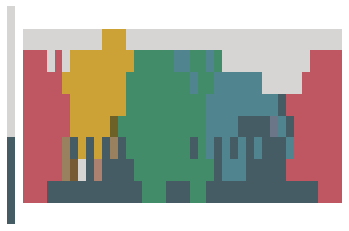

In [20]:
from noga.figures import mode_map, WCS_CHIPS, cnum2ind

q = get_q_for_language(2)
mode_map(q)

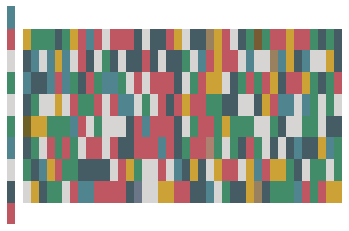

In [27]:
mode_map(np.roll(q, shift=1, axis=0), chips=np.roll(WCS_CHIPS, shift=1, axis=0))

# [cnum2ind(i+1) for i in range(330)]

### Get suboptimal languages

In [22]:
from tqdm import trange

for lid in [2, 32, 35, 108]:
    q = get_q_for_language(lid)
    res = score_q_kl(p_xy, q)
    rates = []
    distortions = []
    worst_qs = []
    for i in trange(1, 5):
        q_new = np.roll(q, shift=i, axis=0)
        res = score_q_kl(p_xy, q_new)
        q_new = mergecols(q_new)
        worst_qs.append(q_new)
        rates.append(res.rate)
        distortions.append(res.distortion)

    worst_permutation_idx = np.argmax(np.array(rates)+np.array(distortions))
    worst_permutation = worst_qs[worst_permutation_idx]
    rate = rates[worst_permutation_idx]
    distortion = distortions[worst_permutation_idx]
    np.save(f"output/worst_qs/{lid}_{rate}_{distortion}.npy", worst_permutation)

100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


In [26]:
# import seaborn as sns

# fig = plt.gcf()
# fig.set_size_inches(7.5, 5.5)
# plt.ylabel("Distortion")
# plt.xlabel("Rate")
# plt.xlim(0,4)
# plt.ylim(2,5)
# fig.tight_layout()
# df = pd.DataFrame({"index": index, "rate": rates, "distortion": distortions})
# sns.scatterplot(x="rate", y="distortion", data=df, hue="index")
# sns.scatterplot(x=[rates[0]], y=[distortions[0]], color="red")
# fp_df = pd.DataFrame(frontier, columns=["rate", "distortion"])
# sns.lineplot(x=fp_df["rate"], y=fp_df["distortion"])
# plt.show()

### Find Frontier

In [ ]:
q, beta, ibscores, qresult, qseq, qseqresults, allqs = fit_ib(p_xy, q0, focalbeta, betas, verbose=1)

items = [str(x+1) for x in range(n_meanings)]
columns = ['M'+str(i) for i in items]

# create data frames for plotting and analysis
ib_scores_df = pd.DataFrame(np.array(ibscores), columns = ['rate', 'distortion', 'elen'])
ib_scores_df['beta'] = betas
ib_scores_df['q'] = allqs
ib_scores_df['Wn'] = [mergecols(q).shape[1] for q in ib_scores_df['q']]

In [ ]:
# The structural phase transitions along the pareto frontier
stochSys = []
for i, q in enumerate(zip(qseq, qseqresults)):
    for w in mergecols(q[0]).transpose():
        stochSys.append([len(qseq)-i, q[1][0], q[1][1]] + list(w))

stochSys = pd.DataFrame(data=np.array(stochSys), columns = ['n', 'rate', 'distortion'] + columns)

In [ ]:
stochSys

In [ ]:
stochSys.cumsum()
stochSys.plot(x="rate", y='distortion')
df = pd.read_csv("output/learnability/result.csv")
sns.scatterplot(x=df.rate, y=df.distortion, hue=df["number of words"], s=df["number of words"])

### The Pareto Frontier
Now let's run the Information Bottleneck Method

In [ ]:
# The structural phase transitions along the pareto frontier
stochSys = []
for i, q in enumerate(zip(qseq, qseqresults)):
    for w in mergecols(q[0]).transpose():
        stochSys.append([len(qseq)-i, q[1][0], q[1][1]] + list(w))

stochSys = pd.DataFrame(data=np.array(stochSys), columns = ['n', 'rate', 'distortion'] + items)


In [ ]:
from scipy.spatial import distance

# compute distance from optimal frontier
def fd(asys, ibscores):
    mind = distance.cdist([[asys['rate'], asys['distortion']]], ibscores[['rate', 'distortion']]).min()
    return mind


def gNID_d(asys, paretoQs, betas, pX):
    mind = np.zeros((len(asys), len(paretoQs)))
    for li in range(len(asys)):
        for qi, q in enumerate(paretoQs):
            mind[li, qi] = gNID(asys.iloc[li]['q'], q, pX)
    return np.argmin(mind, axis=1), np.min(mind, axis=1), betas[np.argmin(mind, axis=1)]

# Plot

In [ ]:
import pandas as pd
lang_df = pd.read_csv("wcs/lang.txt", delimiter="\t", header=None)
languages_dict = {i+1: l for i, l in enumerate(lang_df[1].values)}

frontier = np.load("comm_frontier_points.npy")
frontier1 = np.load("comm_frontier_points3.npy")
frontier2 = np.load("comm_frontier_points4.npy")
frontier = np.concatenate([frontier, frontier1, frontier2], axis=0)

In [ ]:
import pandas as pd
df = pd.read_csv("output/som/result_som.csv")
df.head()

In [ ]:
import pandas as pd
# df = pd.read_csv("output/learnability/result.csv")
# arr = np.load("comm_frontier_points.npy")
sns.set_context("paper")
fig = plt.gcf()
sns.lineplot(x=frontier[:,0], y=frontier[:,1])
# sns.scatterplot(data=df, x="rate", y="distortion")

languages = ["Agarabi", "Culina", "Dyimini", "Yucuna"]
palette_colors = sns.color_palette('tab10')
palette_dict = {l: color for l, color in zip(languages, palette_colors)}

sns.scatterplot(data=language_scores, x="rate", y="distortion", color="gray", s=50)#, hue="Language")
sns.scatterplot(data=language_scores[language_scores.Language.isin(languages)],
                x="rate", y="distortion", hue="Language", s=75, palette=palette_dict, 
                hue_order=languages)
# plt.xlim(0,4)
plt.title("Color Efficiency of Languages")
fig.set_size_inches(7.5, 5.5)
plt.ylabel("Distortion")
plt.xlabel("Rate")
# fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
fig.savefig('color_efficiency.png', dpi=300)
plt.show()

In [ ]:
language_scores["Language"] = language_scores.language.map(languages_dict)

In [ ]:
from tqdm import tqdm
sample_sizes = list(pd.read_csv("output/som/result_som.csv").sort_values("sample_size").sample_size.unique())

# for LANGUAGE in [1,  31,  34, 107]:
for l_id, LANGUAGE in enumerate([2, 32, 35, 108]):
    fig = plt.gcf()
    fig.set_size_inches(7.5, 5.5)
    plt.ylabel("Distortion")
    plt.xlabel("Rate")
    plt.xlim(0,4)
    plt.ylim(2,5)
    fig.tight_layout()

    df = pd.read_csv("output/som/result_som.csv")
    df["Language"]=df.language_id.map(languages_dict)
    df = df[df.language_id == LANGUAGE]
    l = df.Language.values[0]
    df = df.groupby("sample_size")[["distortion", "rate"]].agg(
        distortion_mean=pd.NamedAgg(column="distortion", aggfunc="mean"),
        distortion_std=pd.NamedAgg(column="distortion", aggfunc="std"),
        rate_mean=pd.NamedAgg(column="rate", aggfunc="mean"),
        rate_std=pd.NamedAgg(column="rate", aggfunc="std")).reset_index()
    
    coords_mean = df.sort_values("sample_size")[["rate_mean", "distortion_mean"]].values
    coords_std = df.sort_values("sample_size")[["rate_std", "distortion_std"]].values
    
    language_scores["Language"] = language_scores.language.map(languages_dict)

    sns.scatterplot(data=language_scores[language_scores.language ==  [2, 32, 35, 108][l_id]], 
                x="rate", 
                y="distortion",
                hue="Language",
                # style="Language",
                palette=palette_dict,
                s=100)
    fp_df = pd.DataFrame(frontier, columns=["rate", "distortion"])
    sns.lineplot(x=fp_df["rate"], y=fp_df["distortion"])
    for i, sample_size in tqdm(enumerate(sample_sizes)):        
        if i < coords_mean.shape[0]-1:
            plt.errorbar(coords_mean[i,0], coords_mean[i,1], 
                         yerr=coords_std[i,0], xerr=coords_std[i,1], 
                         fmt='none',
                         ecolor="gray", elinewidth=0.1)
            plt.quiver(*coords_mean[:-1].T[:,i], *np.diff(coords_mean, axis=0).T[:,i], 
                       angles='xy', 
                       scale_units='xy', 
                       scale=0.9, 
                       color=palette_dict[l])
            plt.title(f"Sample Size: {sample_size}")
            fig.savefig(f'animation/{LANGUAGE}/{sample_size}.png', dpi=300)

    plt.savefig(f'{LANGUAGE}_fontier.png', dpi=300)
    plt.show()

In [ ]:
import glob
from PIL import Image

for l in [1,  31,  34, 107]:
    fp_in = f"animation/{l}/*.png"
    fp_out = f"{l}.gif"
    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    images = sorted(glob.glob(fp_in), key=lambda x: int(x.split("/")[-1].split(".")[0]))
    imgs = (Image.open(f) for f in images)
    img = next(imgs)  # extract first image from iterator
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)

In [ ]:
# df = df.groupby("sample_size")[["distortion", "rate"]].mean().reset_index()
df = pd.read_csv("output/som/result_som.csv")
df["Language"]=df.language_id.map(languages_dict)
df = df[df.language_id == LANGUAGE]
l = df.Language.values[0]
# df.groupby("sample_size").distortion.mean()
# )
    
df.groupby("sample_size")[["distortion", "rate"]].agg(
    distortion_mean=pd.NamedAgg(column="distortion", aggfunc="mean"),
    distortion_std=pd.NamedAgg(column="distortion", aggfunc="std"),
    rate_mean=pd.NamedAgg(column="rate", aggfunc="mean"),
    rate_std=pd.NamedAgg(column="rate", aggfunc="std")).reset_index()

In [ ]:
df1 = df[df.language_id.isin([1])].groupby("sample_size").mean().reset_index()
sns.scatterplot(data=df1, 
                x="rate", y="distortion")

df1

In [ ]:
# np.diff(arr[1:], axis=0)
coords = df.sort_values("sample_size")[["rate", "distortion"]].values

#### Calculate distance

In [ ]:
p1 = np.array([2.31669787e-03, 4.74230046e+00])
p2 =  np.array([1.99793648, 2.83398736])
# df = pd.read_csv("output/learnability/result.csv")
df = pd.read_csv("output/som/result_som.csv")
df["distance"] = np.cross(p2-p1,df[["rate", "distortion"]].values-p1)/np.linalg.norm(p2-p1)
df["Language"]=df.language_id.map(languages_dict)

In [ ]:
fig = plt.gcf()
sns.set_context("paper")
sns.scatterplot(data=df[(df.sample_size < 2000)], x="sample_size", y="distance", color="gray")
sns.scatterplot(data=df[(df.sample_size < 2000)&(df.Language.isin(languages))], x="sample_size", 
                y="distance", hue="Language",  palette=palette_dict, s=50, hue_order=languages)

plt.title("Language Distance to Frontier (SOM)")

fig.set_size_inches(7.5, 4.5)
plt.xlabel("Sample Size")
plt.ylabel("Distance to Frontier")
fig.tight_layout()
fig.savefig('dist_frontier_som.png', dpi=300)
plt.show()


In [ ]:
df[(df.language_id == 1)&(df.sample_size < 2000)]

In [ ]:
df = pd.read_csv("output/learnability/result.csv")

In [ ]:
a = frontier[np.abs(frontier[:,0] - (np.ones(frontier.shape[0])*2.5)).argmin()]